<a href="https://colab.research.google.com/github/anshumaannn/Work/blob/main/GooglePlaystore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import warnings

# **Exploratory Data Analysis**

In [ ]:
# Download NLTK stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

# Section 2: Load the Datasets|
df_apps = pd.read_csv('googleplaystore.csv')
print("App dataset shape:", df_apps.shape)
display(df_apps.head())

# Load the User Reviews dataset
df_reviews = pd.read_csv('googleplaystore_user_reviews.csv')
print("Reviews dataset shape:", df_reviews.shape)
display(df_reviews.head())

App dataset shape: (10841, 13)


App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend Play  January 15, 2018               2.0.0   
2               Art & Design    August 1, 2018               1.2.4   
3               Art & Design      June 8, 2018  Varies with device   
4    Art & Design;Creativity     June 20, 2018                 1.1   

    Android Ver  
0  4.0.3 and up  
1  4.0.3 and up  
2  4.0.3 and up  
3    4.2 and up  
4    4.4 and up

Reviews dataset shape: (64295, 5)


App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  
0  Positive                1.00                0.533333  
1  Positive                0.25                0.288462  
2       NaN                 NaN                     NaN  
3  Positive                0.40                0.875000  
4  Positive                1.00                0.300000

In [ ]:
# ---------------------------
# Section 3: Data Cleaning & Transformation for App Details
# ---------------------------

# Remove duplicate rows
df_apps.drop_duplicates(inplace=True)
print("After duplicate removal, shape:", df_apps.shape)


After duplicate removal, shape: (10358, 13)


In [ ]:
# Convert 'Reviews' to integer, handling non-numeric values
df_apps['Reviews'] = pd.to_numeric(df_apps['Reviews'], errors='coerce').astype('Int64')

In [ ]:
# Clean 'Installs': remove commas and '+' then convert to integer, handling non-numeric values
# Convert the 'Installs' column to string type before using .str.replace
df_apps['Installs'] = df_apps['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df_apps['Installs'] = pd.to_numeric(df_apps['Installs'], errors='coerce').astype('Int64')

In [ ]:
# Clean 'Price': remove '$' symbol and convert to float
# --- The fix is below ---
# Ensure 'Price' is treated as a string before using .str
df_apps['Price'] = df_apps['Price'].astype(str).str.replace('$', '', regex=False)
# Now convert to numeric
df_apps['Price'] = pd.to_numeric(df_apps['Price'], errors='coerce').astype(float)

In [ ]:
# Function to convert 'Size' values to bytes then to megabytes
def convert_size(size_str):
    if pd.isnull(size_str) or 'Varies' in size_str:
        return np.nan
    size_str = size_str.strip()
    if size_str.endswith('M'):
        return float(size_str[:-1]) * 1024 * 1024  # Convert MB to bytes
    elif size_str.endswith('k'):
        return float(size_str[:-1]) * 1024         # Convert kB to bytes
    else:
        try:
            return float(size_str)
        except:
            return np.nan

df_apps['Size_bytes'] = df_apps['Size'].apply(convert_size)
df_apps['Size_MB'] = df_apps['Size_bytes'] / (1024 * 1024)

<Figure size 1000x500 with 0 Axes>

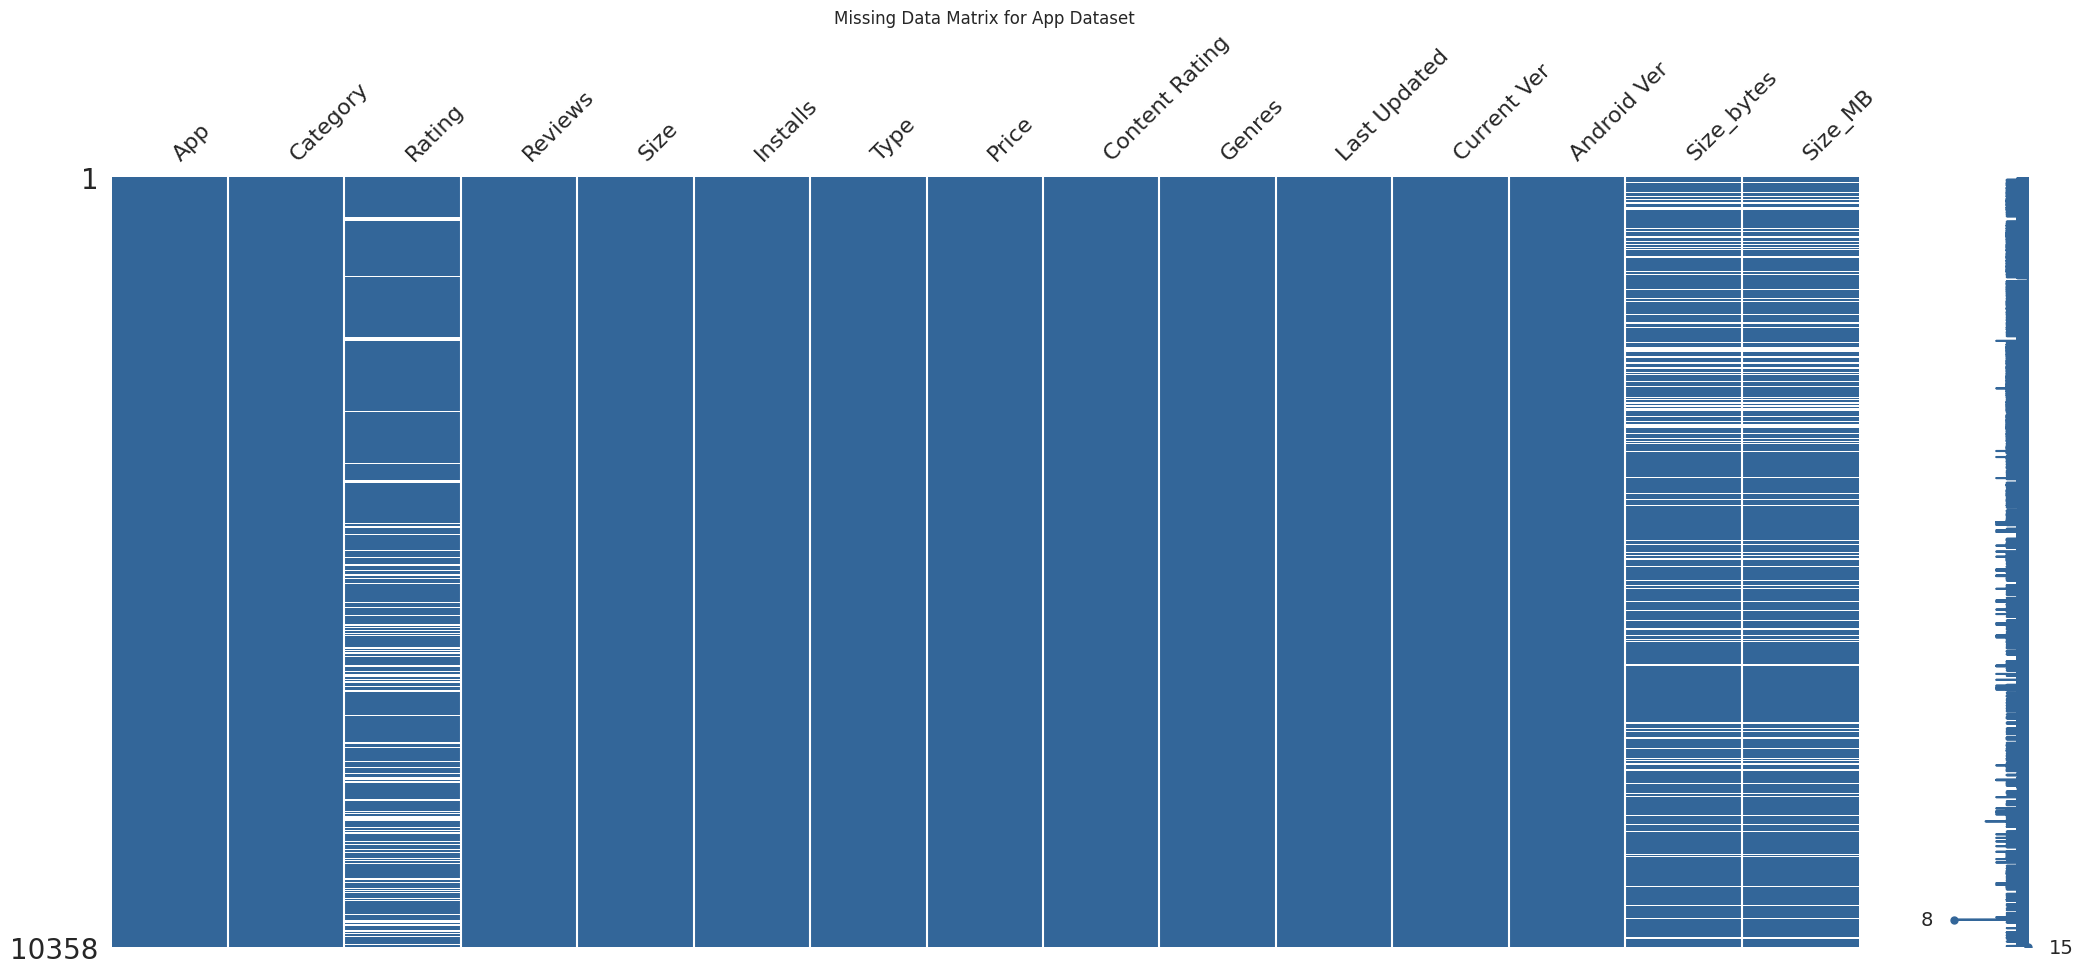

In [ ]:
# Visualize missing data using missingno with custom colors
plt.figure(figsize=(10, 5))
# Use a diverging colormap for better contrast
msno.matrix(df_apps, color=(0.2, 0.4, 0.6))  # Remove sparkline_kwargs
plt.title("Missing Data Matrix for App Dataset")
plt.show()

In [ ]:
# Create Install Categories by binning the 'Installs' column
bins = [-1, 0, 10, 1000, 10000, 100000, 1000000, 10000000, 1e10]
labels = ['No Installs', 'Very Low', 'Low', 'Moderate', 'More Moderate', 'High', 'Very High', 'Top Notch']
df_apps['Installs_cat'] = pd.cut(df_apps['Installs'], bins=bins, labels=labels)

# Impute missing ratings (if any) using the mean rating per install category
if df_apps['Rating'].isnull().sum() > 0:
    cat_mean = df_apps.groupby('Installs_cat')['Rating'].transform('mean')
    df_apps['Rating'].fillna(cat_mean, inplace=True)
print("Missing ratings count:", df_apps['Rating'].isnull().sum())


Missing ratings count: 15


             Rating         Reviews      Size_MB         Installs  \
count  10343.000000         10357.0  8831.000000          10357.0   
mean       4.205893   405904.610602    21.287413  14157759.440668   
std        0.514372  2696777.836748    22.540591  80239553.869019   
min        1.000000             0.0     0.008301              0.0   
25%        4.094593            32.0     4.700000           1000.0   
50%        4.300000          1680.0    13.000000         100000.0   
75%        4.500000         46416.0    29.000000        1000000.0   
max       19.000000      78158306.0   100.000000     1000000000.0   

              Price  
count  10357.000000  
mean       1.030800  
std       16.278625  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      400.000000  


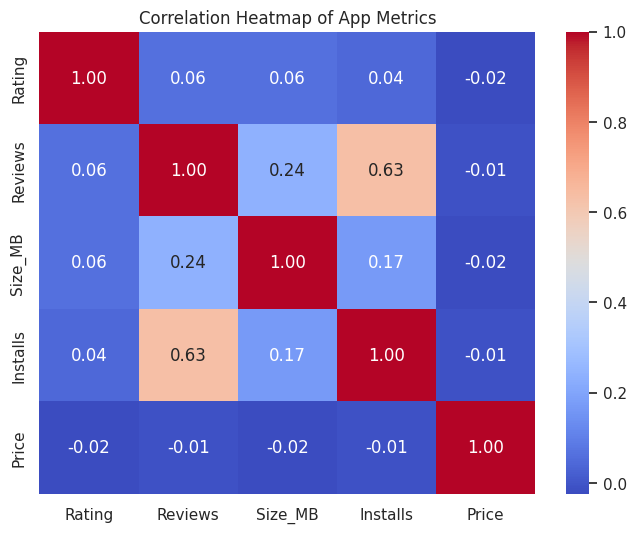

In [ ]:
# Section 4: Advanced EDA & Visualization for App Details
# ---------------------------

# 4.1 Descriptive Statistics & Correlation
print(df_apps[['Rating', 'Reviews', 'Size_MB', 'Installs', 'Price']].describe())

plt.figure(figsize=(8, 6))
sns.heatmap(df_apps[['Rating', 'Reviews', 'Size_MB', 'Installs', 'Price']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of App Metrics")
plt.show()


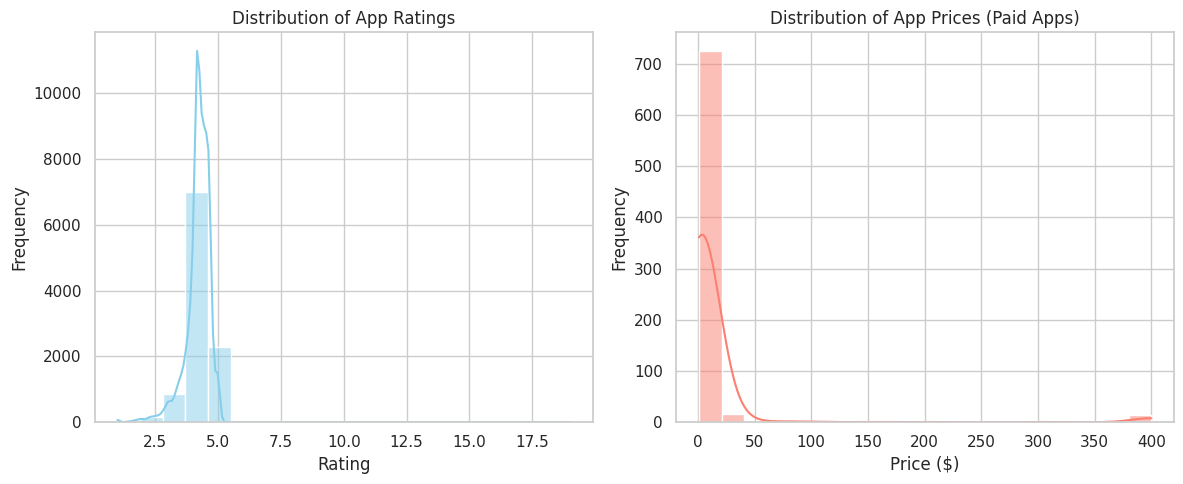

In [ ]:
# 4.2 Distribution Plots: Ratings and Prices (using subplots)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_apps['Rating'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of App Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(df_apps[df_apps['Price'] > 0]['Price'], bins=20, kde=True, color='salmon')
plt.title("Distribution of App Prices (Paid Apps)")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

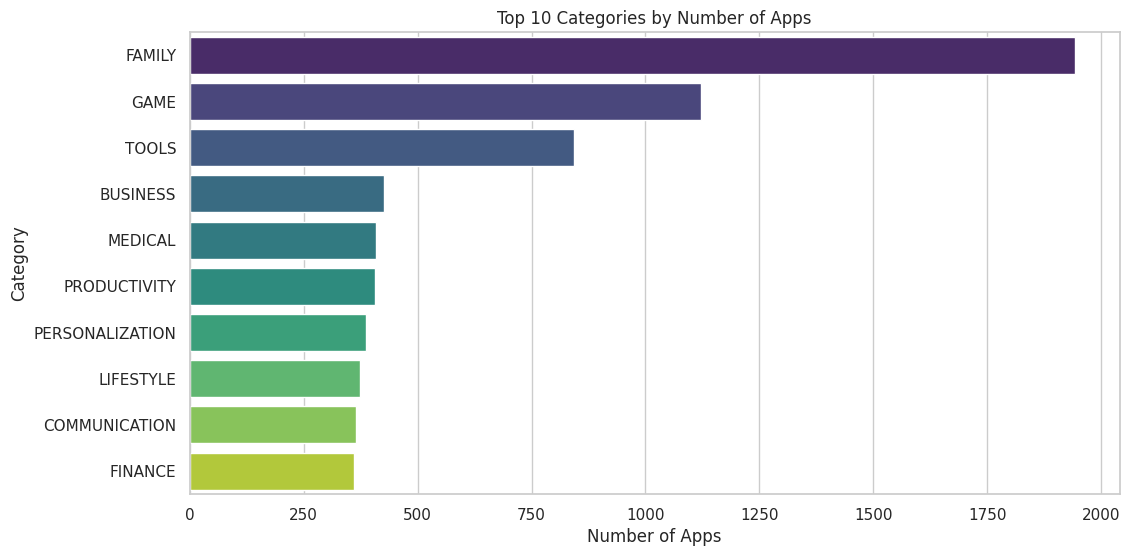

In [ ]:
# 4.3 Comparative Analysis by Category

# Top 10 Categories by App Count
top_cat_count = df_apps['Category'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cat_count.values, y=top_cat_count.index, palette='viridis')
plt.title("Top 10 Categories by Number of Apps")
plt.xlabel("Number of Apps")
plt.ylabel("Category")
plt.show()

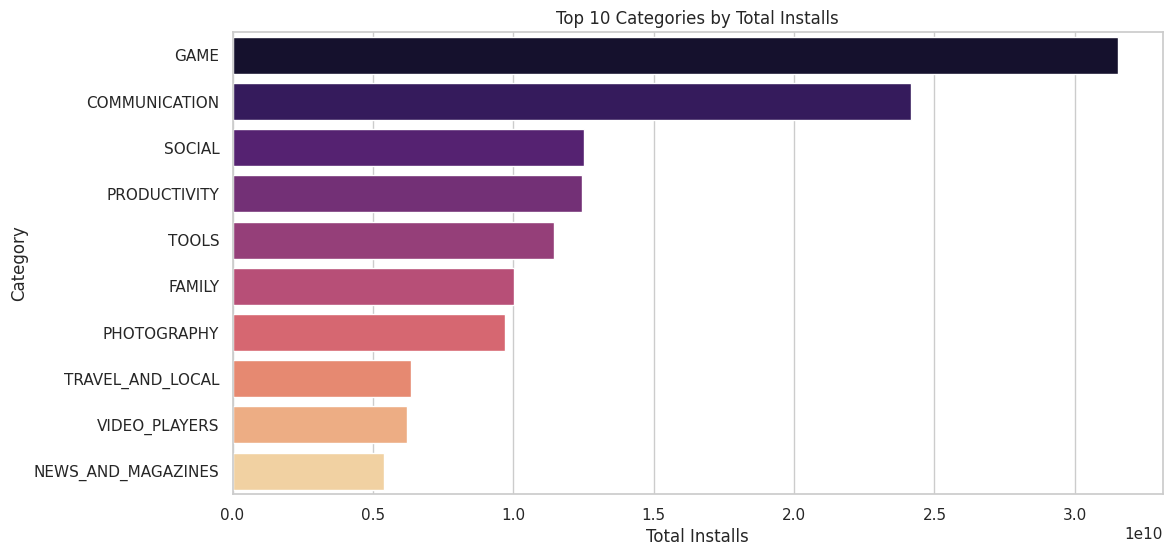

In [ ]:
# Top 10 Categories by Total Installs
top_cat_installs = df_apps.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cat_installs.values, y=top_cat_installs.index, palette='magma')
plt.title("Top 10 Categories by Total Installs")
plt.xlabel("Total Installs")
plt.ylabel("Category")
plt.show()


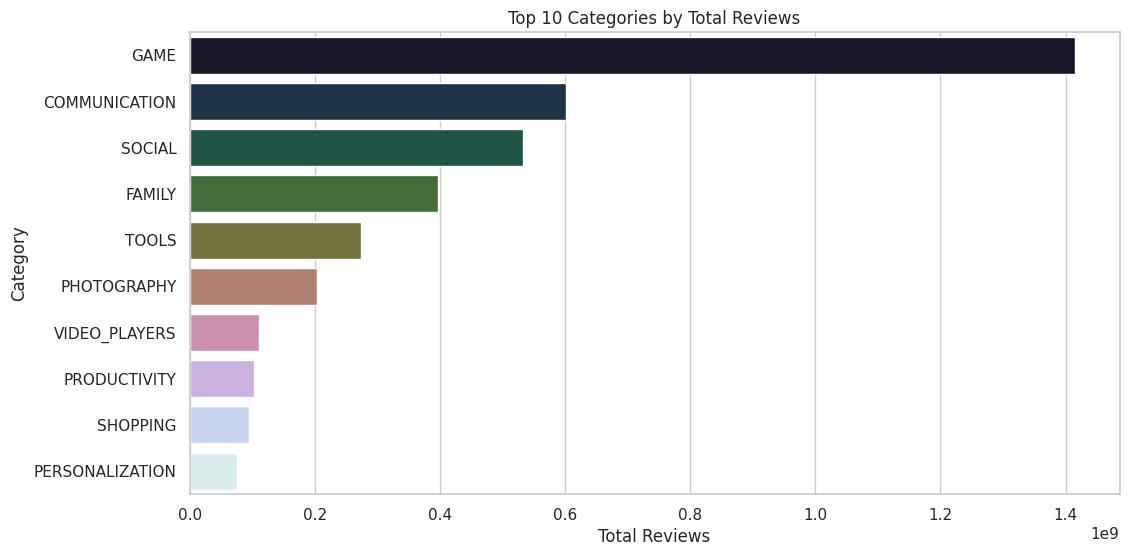

In [ ]:
# Top 10 Categories by Total Reviews
top_cat_reviews = df_apps.groupby('Category')['Reviews'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cat_reviews.values, y=top_cat_reviews.index, palette='cubehelix')
plt.title("Top 10 Categories by Total Reviews")
plt.xlabel("Total Reviews")
plt.ylabel("Category")
plt.show()

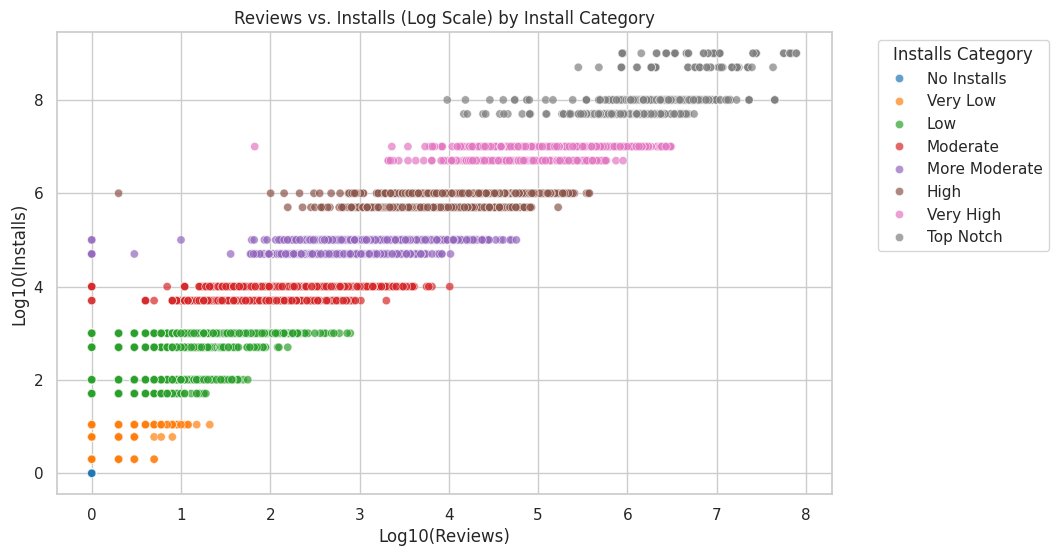

In [ ]:
# 4.4 Relationship Analysis: Scatterplot of Reviews vs. Installs (Log Scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log10(df_apps['Reviews'] + 1), y=np.log10(df_apps['Installs'] + 1),
                hue='Installs_cat', data=df_apps, palette='tab10', alpha=0.7)
plt.xlabel("Log10(Reviews)")
plt.ylabel("Log10(Installs)")
plt.title("Reviews vs. Installs (Log Scale) by Install Category")
plt.legend(title="Installs Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

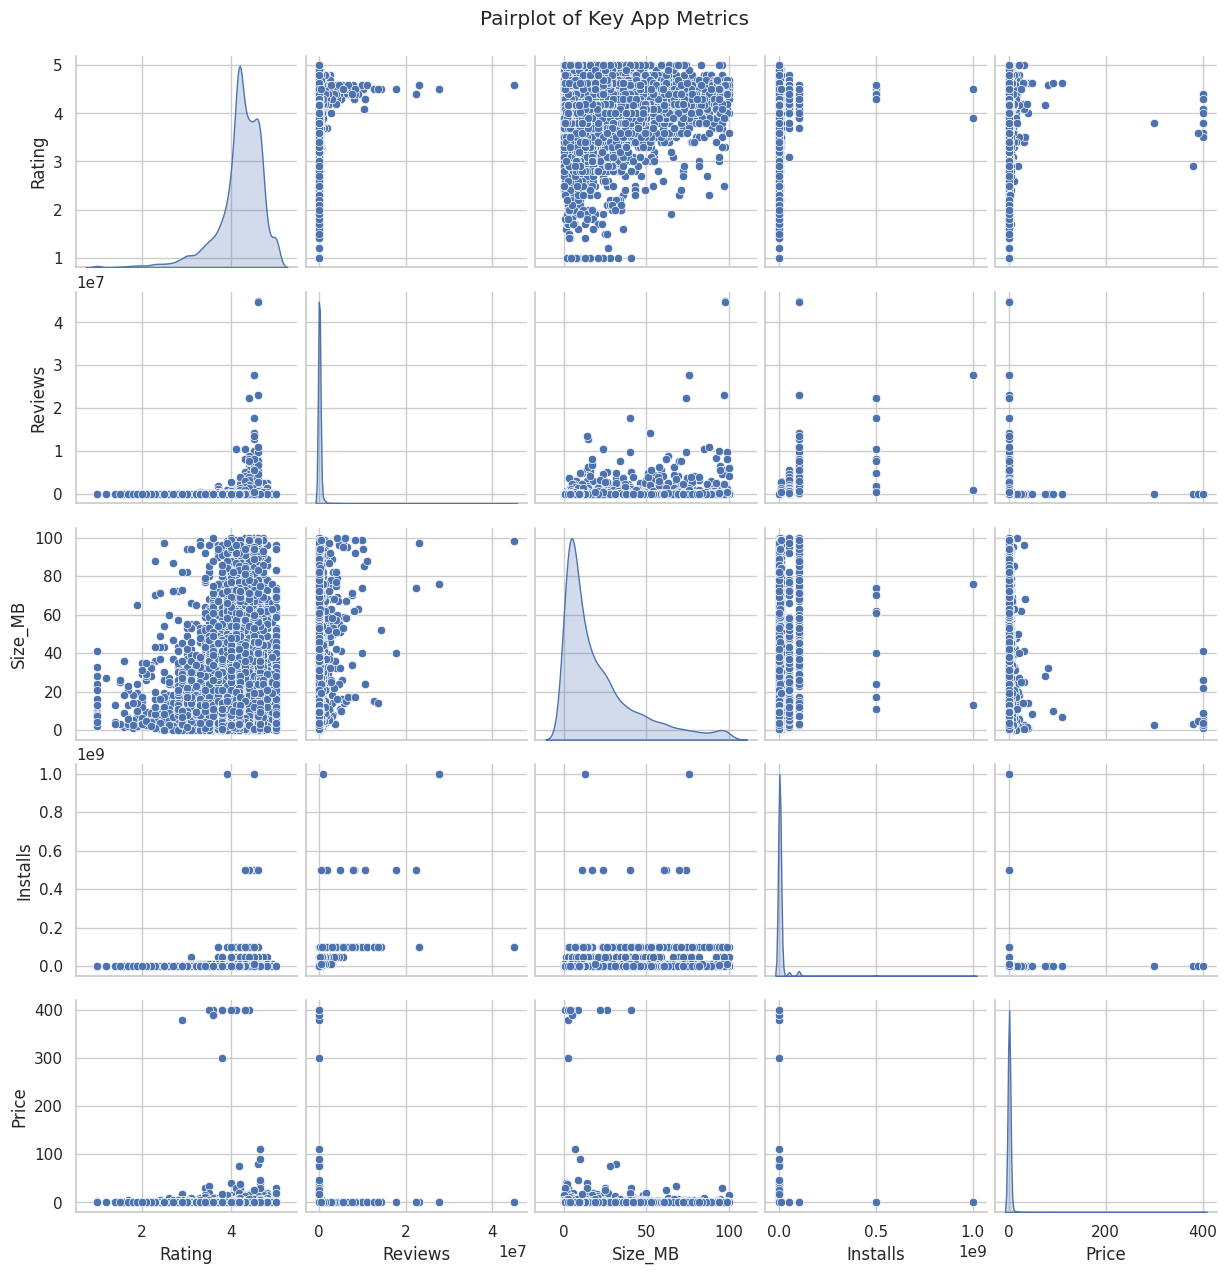

In [ ]:
# 4.5 Pairplot of Key Numerical Variables
sns.pairplot(df_apps[['Rating', 'Reviews', 'Size_MB', 'Installs', 'Price']].dropna(), diag_kind='kde')
plt.suptitle("Pairplot of Key App Metrics", y=1.02)
plt.show()

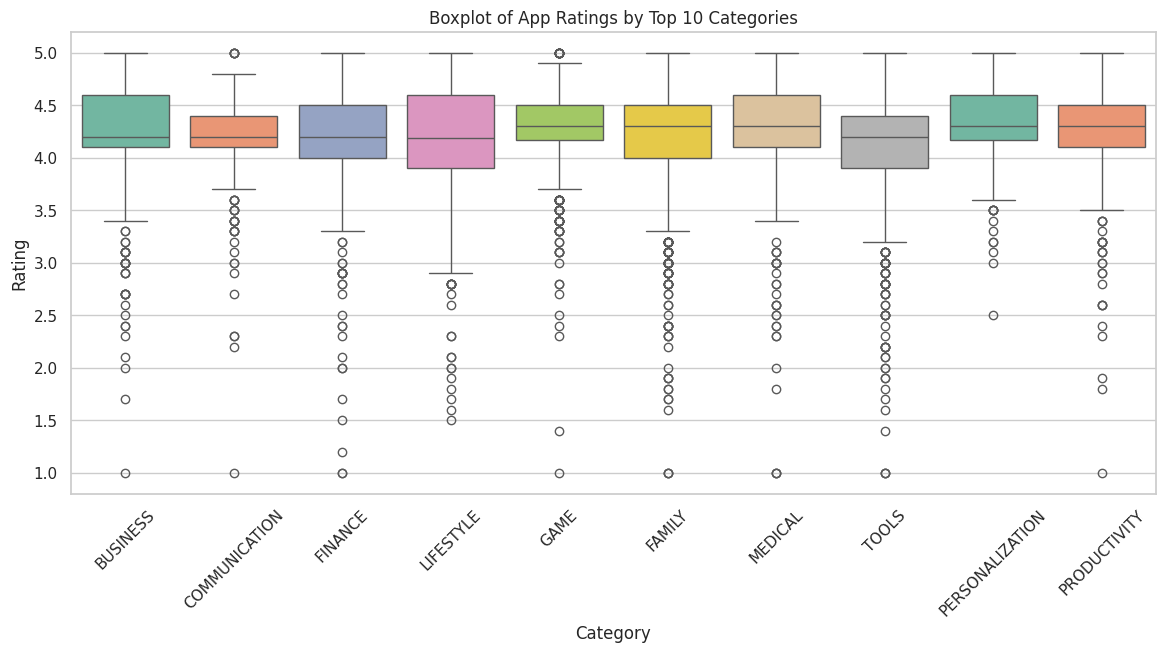

In [ ]:
# 4.6 Advanced Comparative Visual: Boxplot & Violin Plot for Ratings by Top 10 Categories
top_categories = df_apps['Category'].value_counts().head(10).index
plt.figure(figsize=(14, 6))
sns.boxplot(x='Category', y='Rating', data=df_apps[df_apps['Category'].isin(top_categories)], palette='Set2')
plt.title("Boxplot of App Ratings by Top 10 Categories")
plt.xticks(rotation=45)
plt.show()


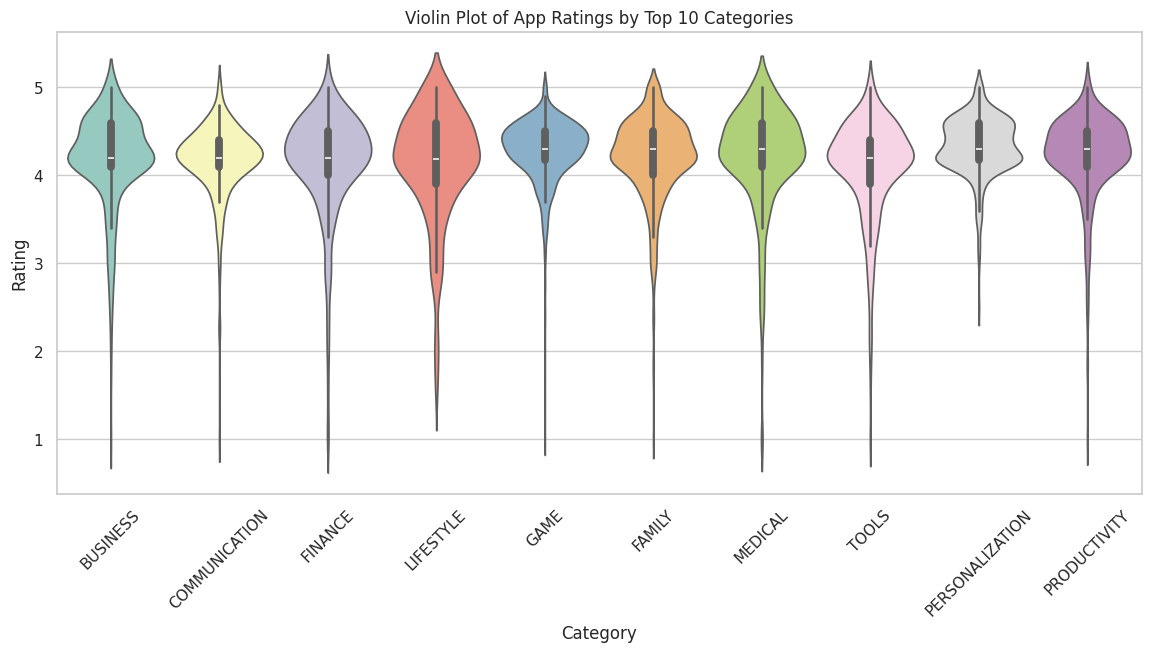

In [ ]:
plt.figure(figsize=(14, 6))
sns.violinplot(x='Category', y='Rating', data=df_apps[df_apps['Category'].isin(top_categories)], palette='Set3')
plt.title("Violin Plot of App Ratings by Top 10 Categories")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# ---------------------------
# Section 5: EDA & Visualization for User Reviews
# ---------------------------

# 5.1 Overview & Descriptive Statistics
print(df_reviews.info())
print(df_reviews[['Sentiment_Polarity', 'Sentiment_Subjectivity']].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB
None
       Sentiment_Polarity  Sentiment_Subjectivity
count        37432.000000            37432.000000
mean             0.182146                0.492704
std              0.351301                0.259949
min             -1.000000                0.000000
25%              0.000000                0.357143
50%              0.150000                0.514286
75%              0.400000                0.650000
max              1.000000                1.000000


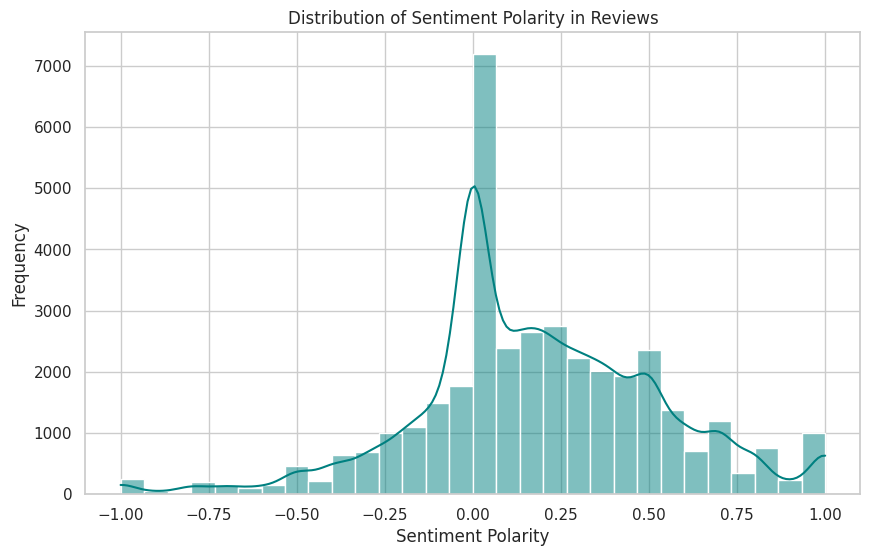

In [ ]:
# 5.2 Distribution of Sentiment Scores
plt.figure(figsize=(10, 6))
sns.histplot(df_reviews['Sentiment_Polarity'], bins=30, kde=True, color='teal')
plt.title("Distribution of Sentiment Polarity in Reviews")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

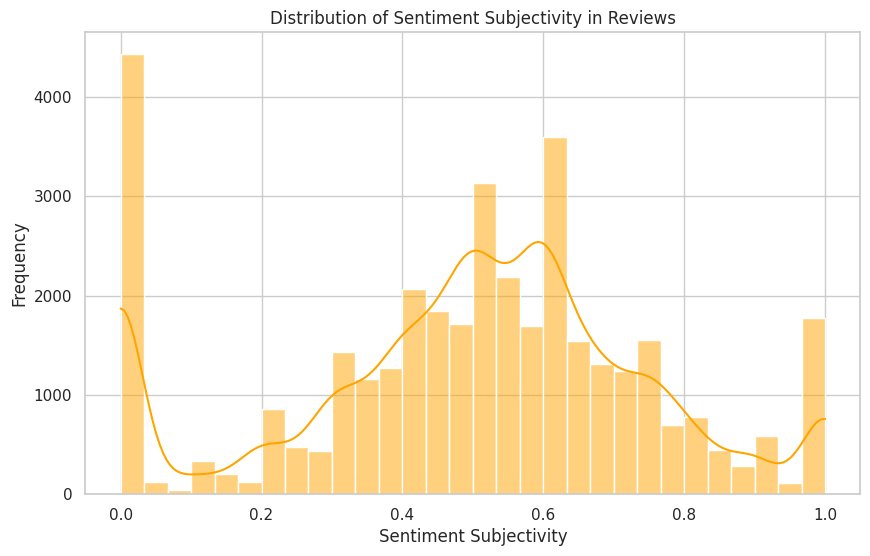

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_reviews['Sentiment_Subjectivity'], bins=30, kde=True, color='orange')
plt.title("Distribution of Sentiment Subjectivity in Reviews")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Frequency")
plt.show()

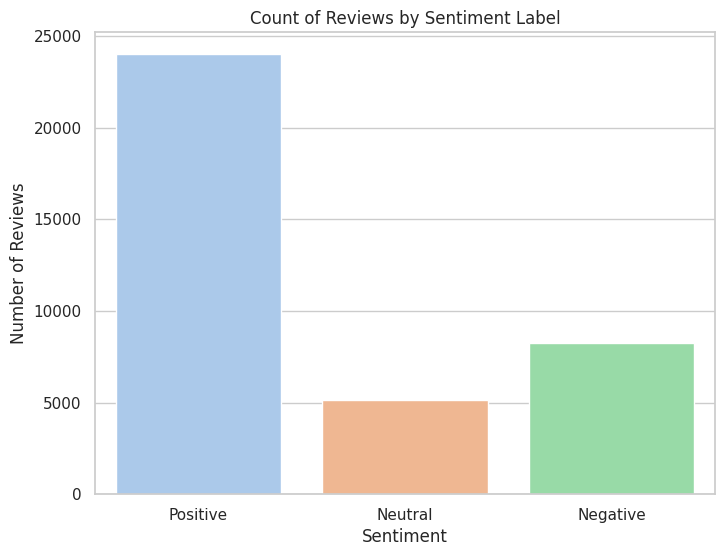

In [ ]:
# 5.3 Count Plot for Sentiment Labels and a Pie Chart
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_reviews, palette='pastel')
plt.title("Count of Reviews by Sentiment Label")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

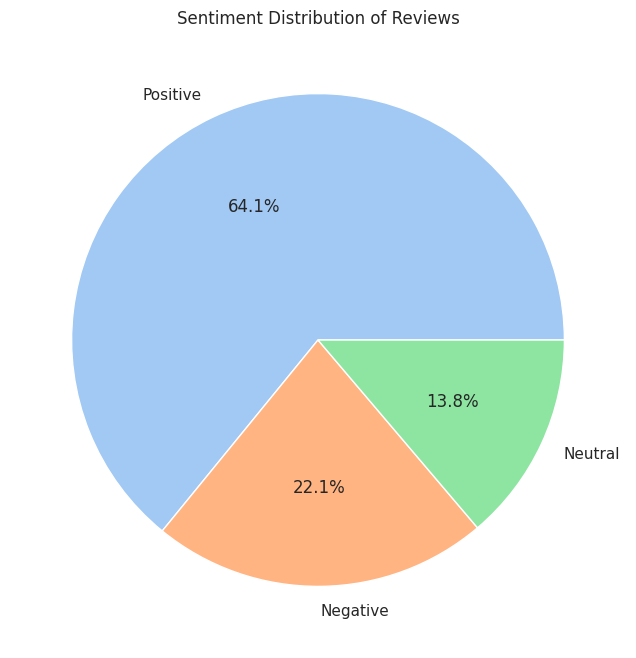

In [ ]:
# Pie chart for sentiment distribution
sentiment_counts = df_reviews['Sentiment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Sentiment Distribution of Reviews")
plt.show()

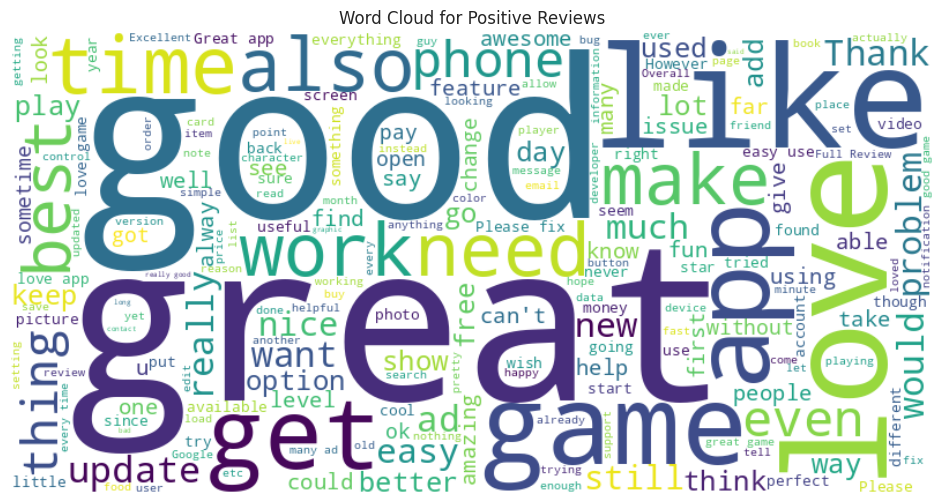

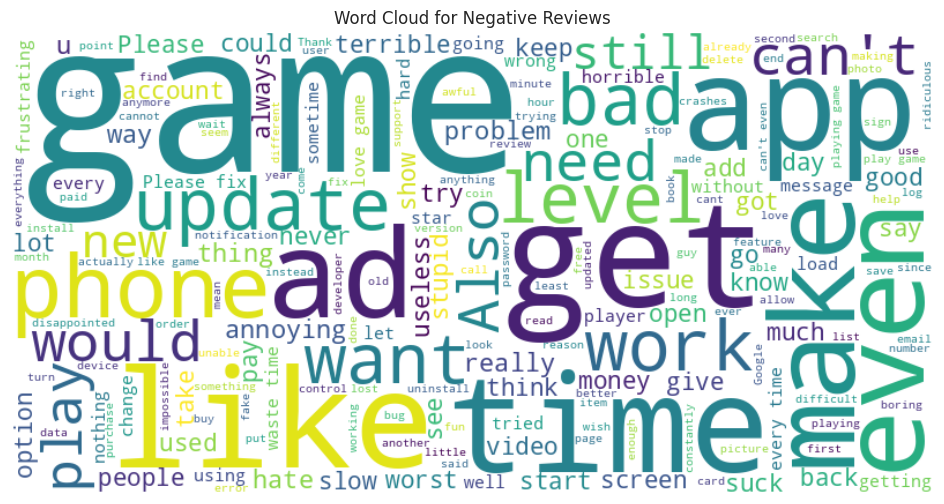

In [ ]:
# 5.4 Word Clouds for Positive and Negative Reviews
def generate_wordcloud(sentiment):
    # Assuming 'Translated_Review' is the correct column name
    # If a different column holds translated reviews, change accordingly
    text = " ".join(df_reviews[df_reviews['Sentiment'] == sentiment]['Translated_Review'].dropna())
    wc = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment} Reviews")
    plt.show()

generate_wordcloud('Positive')
generate_wordcloud('Negative')

In [ ]:
# ---------------------------
# Section 6: Integrated Analysis - Merging App Data with Reviews
# ---------------------------

# Compute the average sentiment polarity per app from the reviews dataset
avg_sentiment = df_reviews.groupby('App')['Sentiment_Polarity'].mean().reset_index()
avg_sentiment.rename(columns={'Sentiment_Polarity': 'Avg_Sentiment_Polarity'}, inplace=True)

# Merge the average sentiment with the app details dataset using the 'App' column
df_merged = pd.merge(df_apps, avg_sentiment, on='App', how='left')
print("Merged dataset shape:", df_merged.shape)
display(df_merged[['App', 'Category', 'Rating', 'Installs', 'Avg_Sentiment_Polarity']].head())


Merged dataset shape: (10358, 17)


App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

   Installs  Avg_Sentiment_Polarity  
0     10000                     NaN  
1    500000                0.152652  
2   5000000                     NaN  
3  50000000                     NaN  
4    100000                     NaN

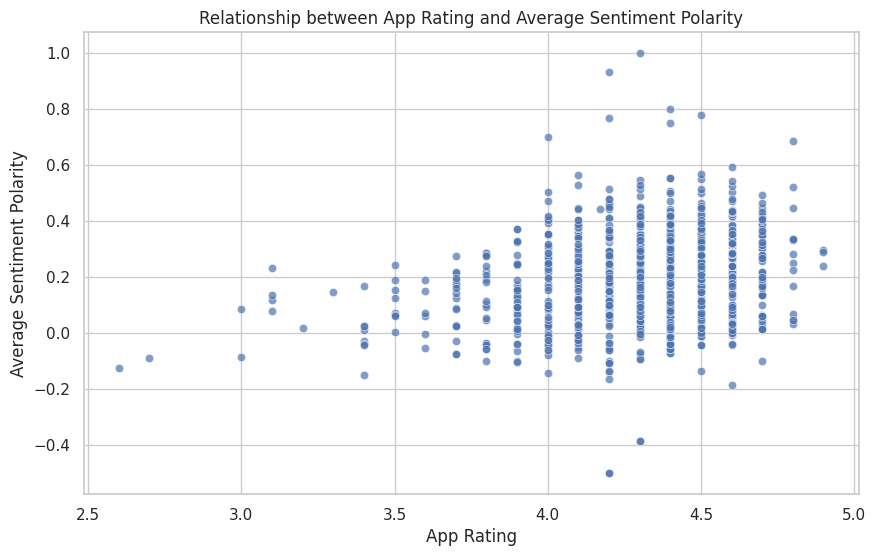

In [ ]:
# Visualize the relationship between App Rating and Average Sentiment Polarity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rating', y='Avg_Sentiment_Polarity', data=df_merged, alpha=0.7, palette='deep')
plt.title("Relationship between App Rating and Average Sentiment Polarity")
plt.xlabel("App Rating")
plt.ylabel("Average Sentiment Polarity")
plt.show()

# -------------------------------------------------------
# End of EDA & Visualization Code

# **App Details Analysis**

In [ ]:
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
df_apps.drop_duplicates(inplace=True)
print("Shape after duplicate removal:", df_apps.shape)

Shape after duplicate removal: (10358, 16)


In [ ]:
df_apps['Size_bytes'] = df_apps['Size'].apply(convert_size)
df_apps['Size_MB'] = df_apps['Size_bytes'] / (1024 * 1024)

In [ ]:
bins = [-1, 0, 10, 1000, 10000, 100000, 1000000, 10000000, 1e10]
labels = ['No Installs', 'Very Low', 'Low', 'Moderate', 'More Moderate', 'High', 'Very High', 'Top Notch']
df_apps['Installs_cat'] = pd.cut(df_apps['Installs'], bins=bins, labels=labels)

In [ ]:
if df_apps['Rating'].isnull().sum() > 0:
    cat_mean = df_apps.groupby('Installs_cat')['Rating'].transform('mean')
    df_apps['Rating'].fillna(cat_mean, inplace=True)
print("Missing ratings count:", df_apps['Rating'].isnull().sum())

Missing ratings count: 15


In [ ]:
df_apps['Last Updated'] = pd.to_datetime(df_apps['Last Updated'], errors='coerce', format='%B %d, %Y')
# Try to convert to datetime using the specified format, handle errors gracefully
df_apps['Last Updated'] = pd.to_datetime(df_apps['Last Updated'], infer_datetime_format=True, errors='coerce')
#If the format is not consistent, this helps infer it for different elements

df_apps['Days_Since_Update'] = (pd.to_datetime('today') - df_apps['Last Updated']).dt.days

In [ ]:
!pip install plotly
import plotly.express as px

In [ ]:
fig_bubble = px.scatter(
    df_apps.dropna(subset=['Reviews']),  # Drop rows with missing 'Reviews'
    x='Price',
    y='Installs',
    size='Reviews',
    color='Category',
    hover_name='App',
    log_y=True,
    title="Interactive Bubble Chart: Price vs Installs (Log Scale)",
    labels={'Installs': 'Installs (log scale)', 'Price': 'Price ($)'},
    # Increased size_max for larger bubbles:
    size_max=60,
    # Custom color scale for better contrast:
    color_discrete_sequence=px.colors.qualitative.Dark24,
    # Adjusted opacity for overlapping bubbles:
    opacity=0.7
)

fig_bubble.update_layout(
    # Improve layout for better readability:
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",  # Anchor legend to bottom
        y=1.02,  # Position legend slightly below the plot
        xanchor="right",
        x=1
    )
)

fig_bubble.show()

In [ ]:
df_apps['Update_Month'] = df_apps['Last Updated'].dt.to_period('M').dt.to_timestamp()
monthly_rating = df_apps.groupby('Update_Month')['Rating'].mean().reset_index()

fig_time = px.line(
    monthly_rating,
    x='Update_Month',
    y='Rating',
    title="Trend of Average App Rating Over Time",
    labels={'Update_Month': 'Month', 'Rating': 'Average Rating'}
)
fig_time.show()


In [ ]:
from sklearn.preprocessing import StandardScaler # Import StandardScaler

features = df_apps[['Reviews', 'Size_MB', 'Installs', 'Price', 'Rating']].fillna(0)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(scaled_features)
df_apps['PC1'] = pca_components[:, 0]
df_apps['PC2'] = pca_components[:, 1]


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
df_apps['Cluster'] = kmeans.fit_predict(pca_components)

In [ ]:
fig_pca = px.scatter(
    df_apps,
    x='PC1',
    y='PC2',
    color='Cluster',
    hover_data=['App', 'Category', 'Rating'],
    title="PCA Clustering of Apps (Interactive)",
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'}
)
fig_pca.show()

# **User Reviews Analysis**

In [ ]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB
None


In [ ]:
print(df_reviews[['Sentiment_Polarity', 'Sentiment_Subjectivity']].describe())

       Sentiment_Polarity  Sentiment_Subjectivity
count        37432.000000            37432.000000
mean             0.182146                0.492704
std              0.351301                0.259949
min             -1.000000                0.000000
25%              0.000000                0.357143
50%              0.150000                0.514286
75%              0.400000                0.650000
max              1.000000                1.000000


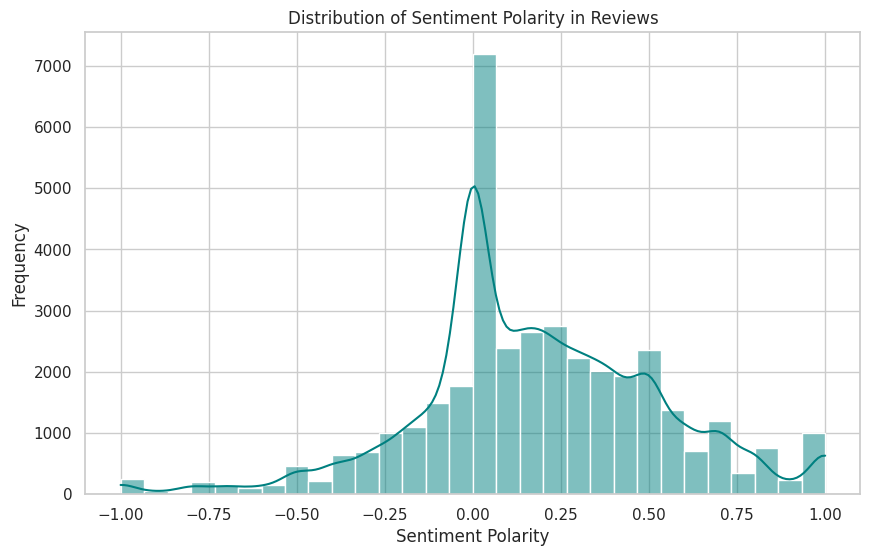

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_reviews['Sentiment_Polarity'], bins=30, kde=True, color='teal')
plt.title("Distribution of Sentiment Polarity in Reviews")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()


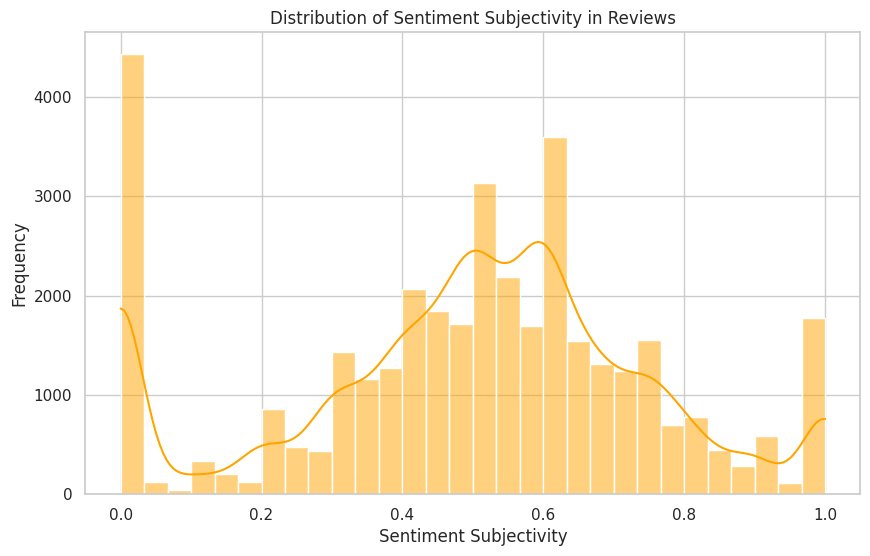

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_reviews['Sentiment_Subjectivity'], bins=30, kde=True, color='orange')
plt.title("Distribution of Sentiment Subjectivity in Reviews")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Frequency")
plt.show()

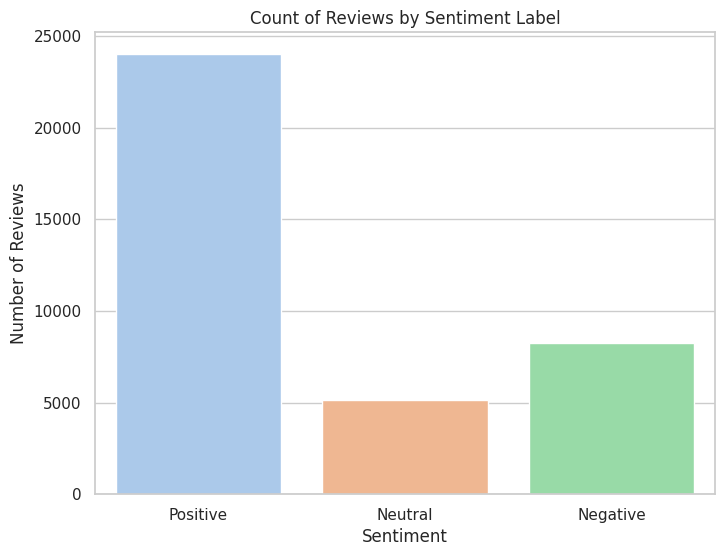

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df_reviews, palette='pastel')
plt.title("Count of Reviews by Sentiment Label")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

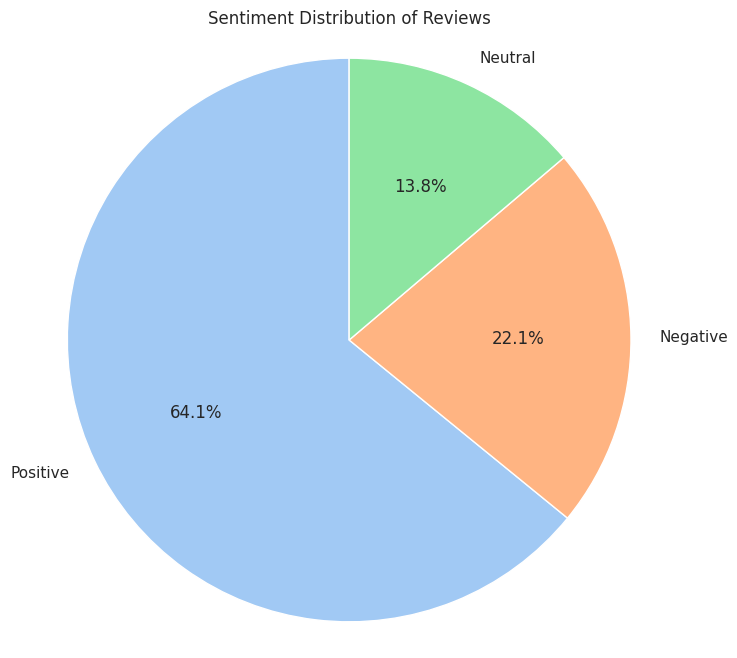

In [ ]:
sentiment_counts = df_reviews['Sentiment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=sns.color_palette('pastel'), startangle=90)
plt.title("Sentiment Distribution of Reviews")
plt.axis('equal')
plt.show()

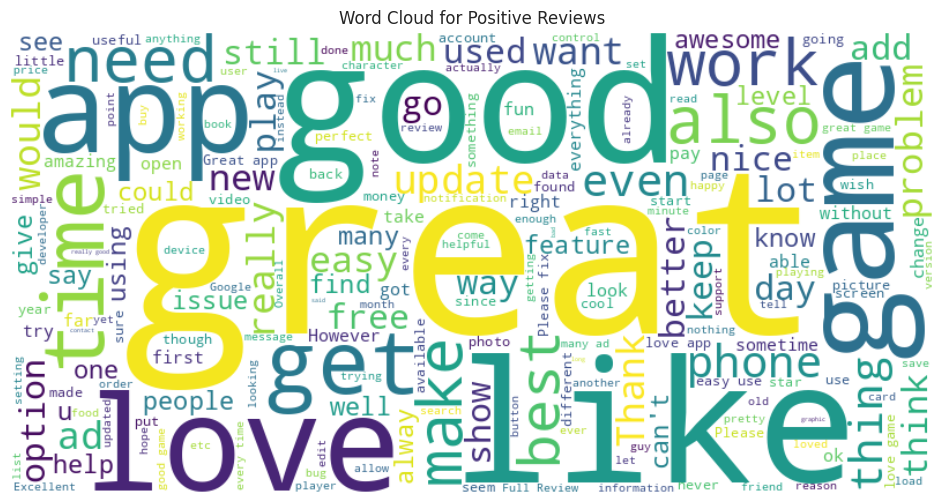

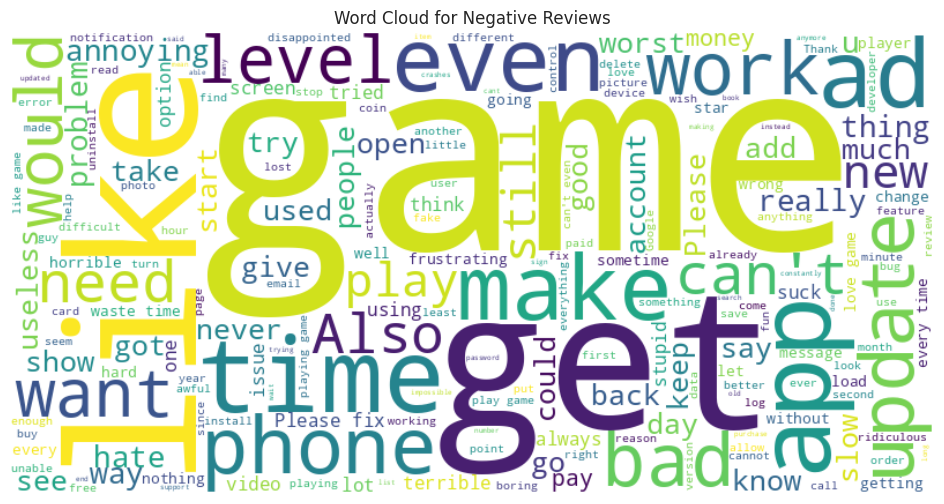

In [ ]:
def generate_wordcloud(sentiment_label):
    # Combine review texts for the specified sentiment, using 'Translated_Review' instead of 'Translate'
    text = " ".join(df_reviews[df_reviews['Sentiment'] == sentiment_label]['Translated_Review'].dropna())
    wc = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment_label} Reviews")
    plt.show()

# Generate word clouds for 'Positive' and 'Negative' reviews
generate_wordcloud('Positive')
generate_wordcloud('Negative')

# **Integrated Analysis**

In [ ]:
avg_sentiment = df_reviews.groupby('App')['Sentiment_Polarity'].mean().reset_index()
avg_sentiment.rename(columns={'Sentiment_Polarity': 'Avg_Sentiment_Polarity'}, inplace=True)

In [ ]:
# Merge the average sentiment with the app details dataset on the 'App' column
df_merged = pd.merge(df_apps, avg_sentiment, on='App', how='left')
print("Merged dataset shape:", df_merged.shape)
display(df_merged[['App', 'Category', 'Rating', 'Installs', 'Avg_Sentiment_Polarity']].head())

Merged dataset shape: (10358, 22)


App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

   Installs  Avg_Sentiment_Polarity  
0     10000                     NaN  
1    500000                0.152652  
2   5000000                     NaN  
3  50000000                     NaN  
4    100000                     NaN

In [ ]:
# Merge the average sentiment with the app details dataset on the 'App' column
df_merged = pd.merge(df_apps, avg_sentiment, on='App', how='left')
print("Merged dataset shape:", df_merged.shape)
display(df_merged[['App', 'Category', 'Rating', 'Installs', 'Avg_Sentiment_Polarity']].head())


Merged dataset shape: (10358, 22)


App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

   Installs  Avg_Sentiment_Polarity  
0     10000                     NaN  
1    500000                0.152652  
2   5000000                     NaN  
3  50000000                     NaN  
4    100000                     NaN

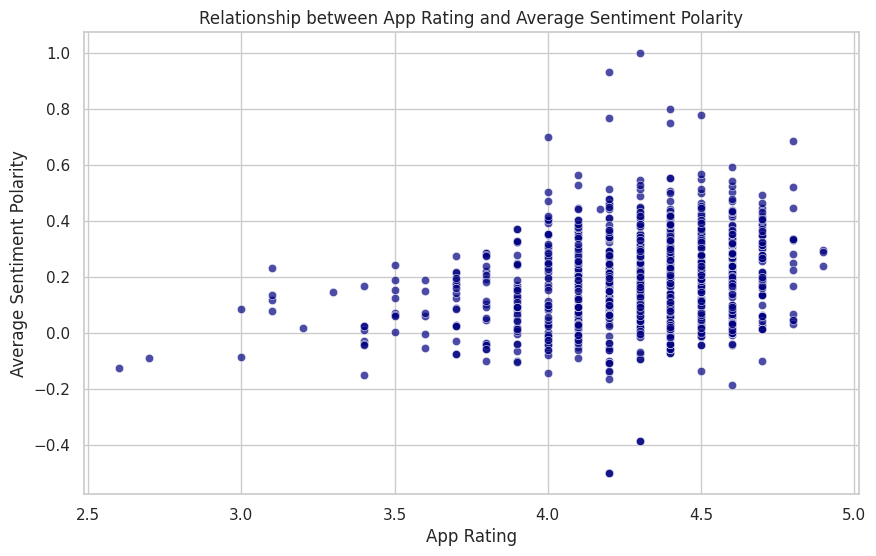

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Rating', y='Avg_Sentiment_Polarity', data=df_merged, alpha=0.7, color='navy')
plt.title("Relationship between App Rating and Average Sentiment Polarity")
plt.xlabel("App Rating")
plt.ylabel("Average Sentiment Polarity")
plt.show()


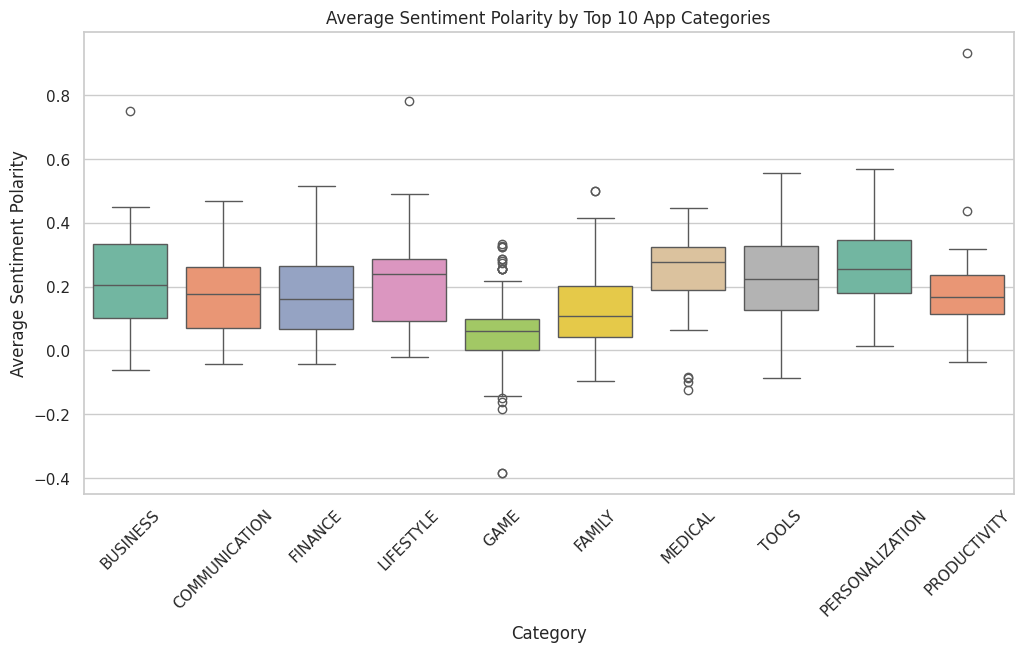

In [ ]:
top_categories = df_merged['Category'].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='Avg_Sentiment_Polarity',
            data=df_merged[df_merged['Category'].isin(top_categories)], palette='Set2')
plt.title("Average Sentiment Polarity by Top 10 App Categories")
plt.xlabel("Category")
plt.ylabel("Average Sentiment Polarity")
plt.xticks(rotation=45)
plt.show()


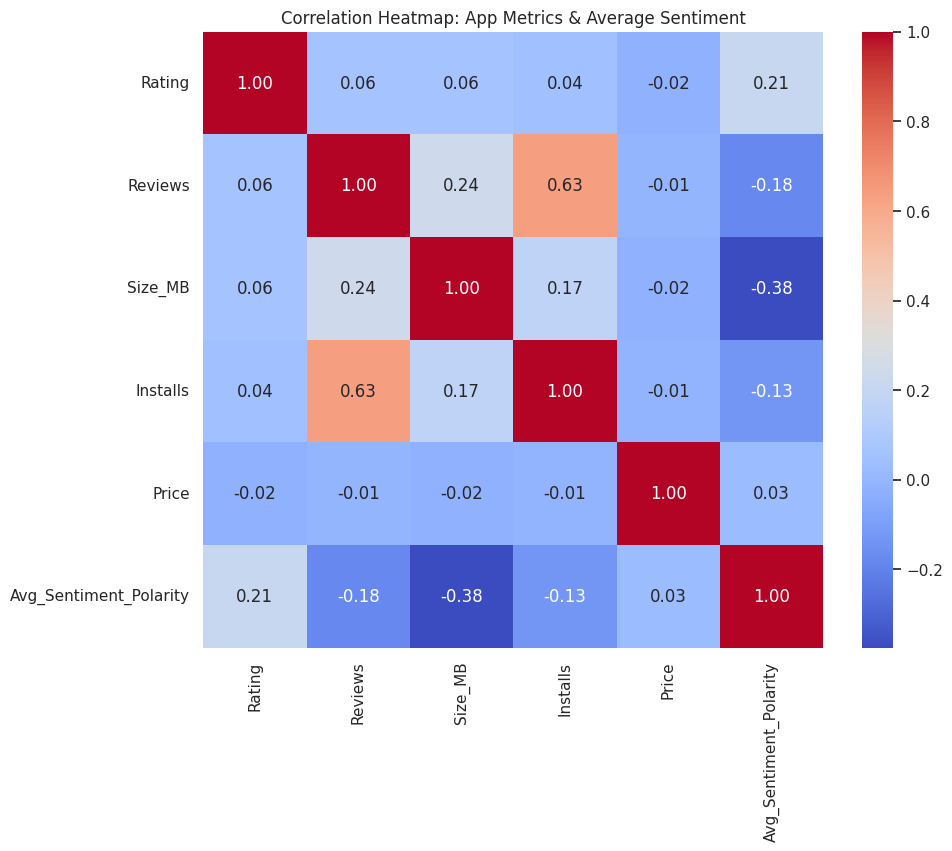

In [ ]:
plt.figure(figsize=(10,8))
corr = df_merged[['Rating', 'Reviews', 'Size_MB', 'Installs', 'Price', 'Avg_Sentiment_Polarity']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: App Metrics & Average Sentiment")
plt.show()

# **Multi-part enhancement**

**Predictive Modeling**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Use the previously cleaned df_apps DataFrame
# We'll predict 'Rating' using numeric features and one-hot encoded 'Category'
features = df_apps[['Reviews', 'Size_MB', 'Installs', 'Price']].fillna(0)
# One-hot encode the 'Category'
features = pd.concat([features, pd.get_dummies(df_apps['Category'], prefix='Cat')], axis=1)
target = df_apps['Rating']

# --- The fix ---
# Impute missing values in the target variable before splitting
target = target.fillna(target.mean()) # or target.median(), depending on your preference

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE for Rating Prediction:", rmse)

RMSE for Rating Prediction: 0.4709688245272875


**Time Series Analysis**

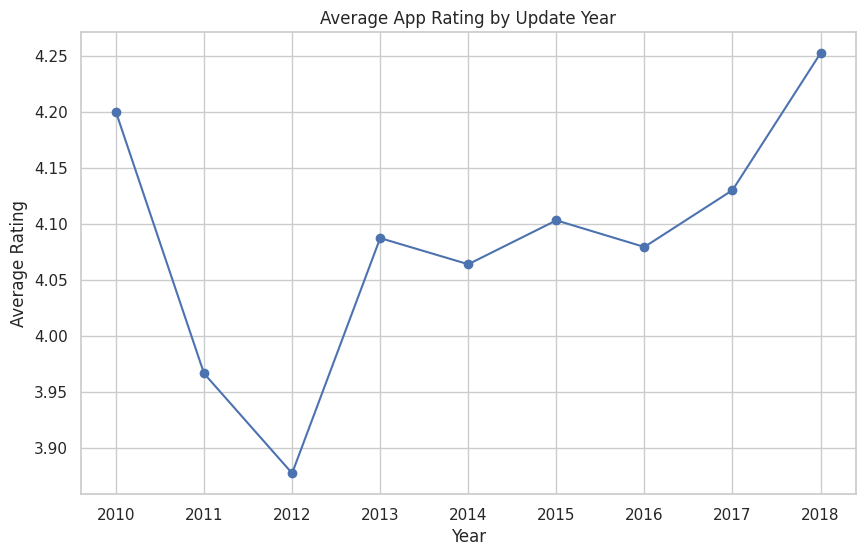

In [ ]:
# Convert 'Last Updated' to datetime
df_apps['Last Updated'] = pd.to_datetime(df_apps['Last Updated'])
# Extract year and month
df_apps['Update_Year'] = df_apps['Last Updated'].dt.year
df_apps['Update_Month'] = df_apps['Last Updated'].dt.month

# Calculate average rating by update year
yearly_rating = df_apps.groupby('Update_Year')['Rating'].mean().reset_index()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(yearly_rating['Update_Year'], yearly_rating['Rating'], marker='o', linestyle='-')
plt.title("Average App Rating by Update Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()


**Advanced NLP Techniques (Topic Modeling)**

In [ ]:
!pip install gensim

In [ ]:
import gensim
from gensim import corpora
import nltk
import pandas as pd # Import pandas
from nltk.corpus import stopwords # Import stopwords

# Download the 'punkt_tab' data package
nltk.download('punkt_tab')
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the User Reviews dataset  # Load the DataFrame here
df_reviews = pd.read_csv('googleplaystore_user_reviews.csv')

# Prepare review texts
# Use 'Translated_Review' instead of 'Translate'
reviews = df_reviews['Translated_Review'].dropna().tolist()
tokenized_reviews = [nltk.word_tokenize(review.lower()) for review in reviews]

# Remove non-alphabetic tokens and stopwords
tokenized_reviews = [[word for word in tokens if word.isalpha() and word not in stop_words]
                     for tokens in tokenized_reviews]

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Build an LDA model with 5 topics
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(0, '0.025*"like" + 0.013*"would" + 0.012*"add" + 0.010*"people" + 0.009*"could"')
(1, '0.031*"good" + 0.024*"love" + 0.019*"app" + 0.018*"easy" + 0.015*"like"')
(2, '0.074*"game" + 0.023*"ads" + 0.020*"get" + 0.019*"play" + 0.016*"fun"')
(3, '0.016*"update" + 0.014*"time" + 0.014*"phone" + 0.012*"work" + 0.011*"even"')
(4, '0.037*"great" + 0.015*"app" + 0.010*"useful" + 0.009*"keep" + 0.008*"work"')


**Interactive Dashboards**

In [ ]:
import plotly.express as px

# Assuming df_merged (from integrated analysis) has been created
fig = px.scatter(df_merged, x='Rating', y='Avg_Sentiment_Polarity', color='Category',
                 hover_data=['App'], title="Interactive Scatterplot: Rating vs. Average Sentiment")
fig.show()


**User Segmentation & Clustering**

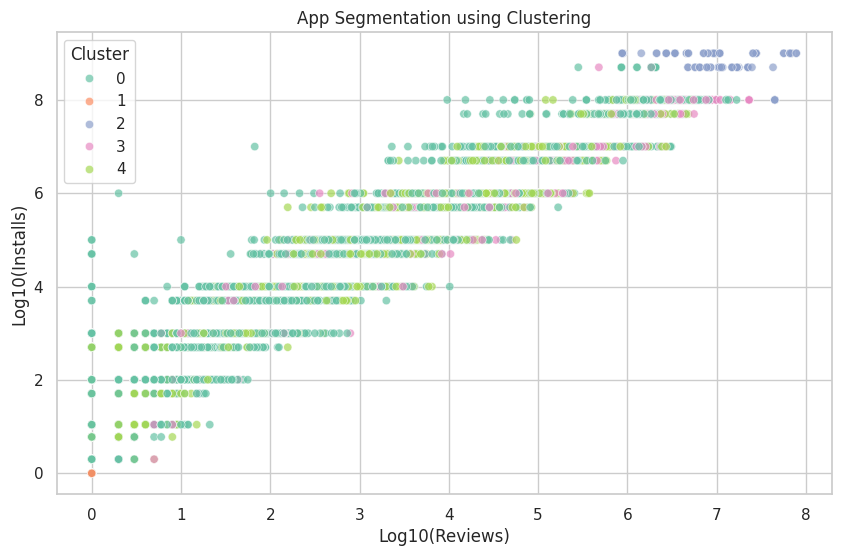

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features_cluster = df_apps[['Reviews', 'Size_MB', 'Installs', 'Price']].fillna(0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_cluster)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_apps['Cluster'] = kmeans.fit_predict(features_scaled)

# Visualize clusters on a scatter plot (log-transformed Reviews vs. Installs)
plt.figure(figsize=(10,6))
sns.scatterplot(x=np.log10(df_apps['Reviews'] + 1), y=np.log10(df_apps['Installs'] + 1),
                hue='Cluster', data=df_apps, palette='Set2', alpha=0.7)
plt.title("App Segmentation using Clustering")
plt.xlabel("Log10(Reviews)")
plt.ylabel("Log10(Installs)")
plt.legend(title="Cluster")
plt.show()

**A/B Testing Insights**

In [ ]:
from scipy.stats import ttest_ind

# For demonstration, let's split apps into two groups based on Last Updated date.
group_a = df_apps[df_apps['Last Updated'] < '2018-01-01']['Rating']
group_b = df_apps[df_apps['Last Updated'] >= '2018-01-01']['Rating']

t_stat, p_val = ttest_ind(group_a, group_b, nan_policy='omit')
print("T-statistic:", t_stat)
print("P-value:", p_val)

T-statistic: -14.232382938308142
P-value: 1.5507346260096807e-45


**Revenue Analysis**

In [ ]:
# Focus on Paid apps
paid_apps = df_apps[df_apps['Type'] == 'Paid'].copy()
# Estimate revenue (simple calculation: Price x Installs)
paid_apps['Estimated_Revenue'] = paid_apps['Price'] * paid_apps['Installs']
top_revenue_apps = paid_apps.sort_values(by='Estimated_Revenue', ascending=False).head(10)
print(top_revenue_apps[['App', 'Price', 'Installs', 'Estimated_Revenue']])

                                App   Price  Installs  Estimated_Revenue
2241                      Minecraft    6.99  10000000         69900000.0
4347                      Minecraft    6.99  10000000         69900000.0
5351                      I am rich  399.99    100000         39999000.0
5356              I Am Rich Premium  399.99     50000         19999500.0
4034                  Hitman Sniper    0.99  10000000          9900000.0
7417  Grand Theft Auto: San Andreas    6.99   1000000          6990000.0
5578        Sleep as Android Unlock    5.99   1000000          5990000.0
2883            Facetune - For Free    5.99   1000000          5990000.0
8804            DraStic DS Emulator    4.99   1000000          4990000.0
4367       I'm Rich - Trump Edition  400.00     10000          4000000.0


**Geographical Analysis**

In [ ]:
# Pseudo-code example:
# Assume you have an additional 'Country' column or can infer regions from review language.
# You could then group by Country and analyze metrics such as total installs or average rating.
#
# Example:
# country_installs = df_apps.groupby('Country')['Installs'].sum().reset_index()
# plt.figure(figsize=(12,6))
# sns.barplot(x='Country', y='Installs', data=country_installs)
# plt.title("Total Installs by Country")
# plt.show()
#
print("Geographical analysis requires location data. If available, group the data by country/region to visualize regional trends.")

Geographical analysis requires location data. If available, group the data by country/region to visualize regional trends.
